<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_01_29_Conv2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Conv2d Under The Hood

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/j19Wdlu7Rtg).

## Acknowledgment:
This tutorial was very helpful [CS231n Course Notes](https://cs231n.github.io/convolutional-networks/).

## A simple convolution example by hand
The following screenshot was taken from [CS231n Course Notes](https://cs231n.github.io/convolutional-networks/). Two $3 \times 3$ filters were passed across a $5 \times 5$ image with `padding=1`.

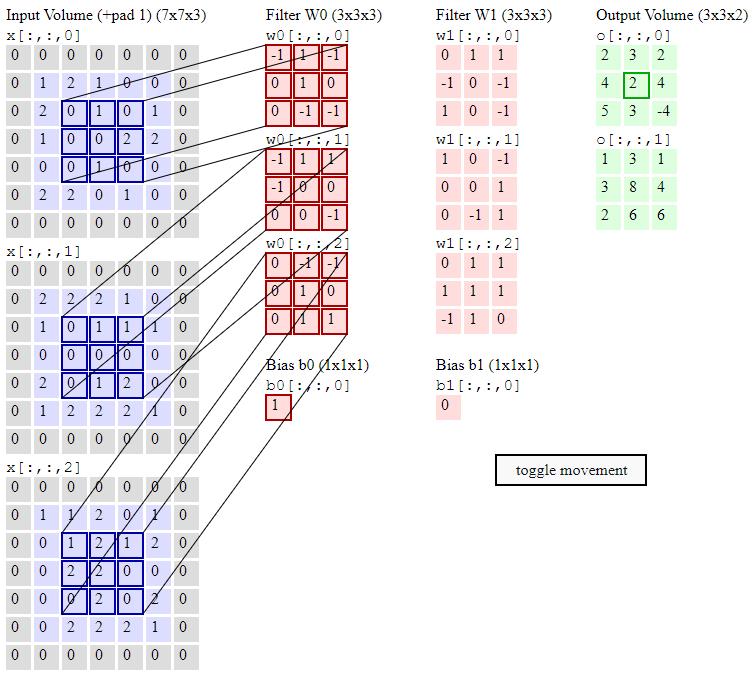

Here, we are computing how did we get $2$ in the output:

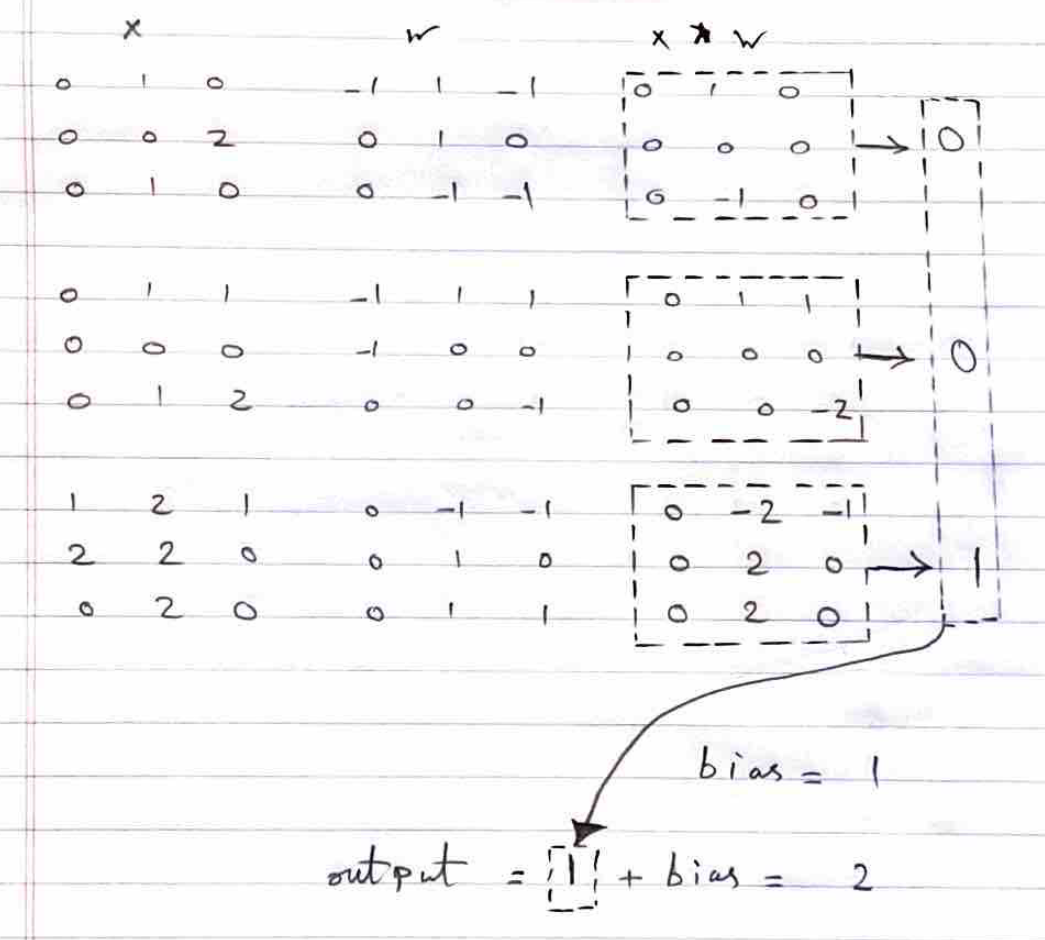

# Visualizing convolutions as matrix multiplication
Given a $32 \times 32 \times 3$ image, we are passing $4$ filters of size $5 \times 5$. For simplicity we are setting `padding = 0` and `stride = 1`. Let's compute the size of the output:

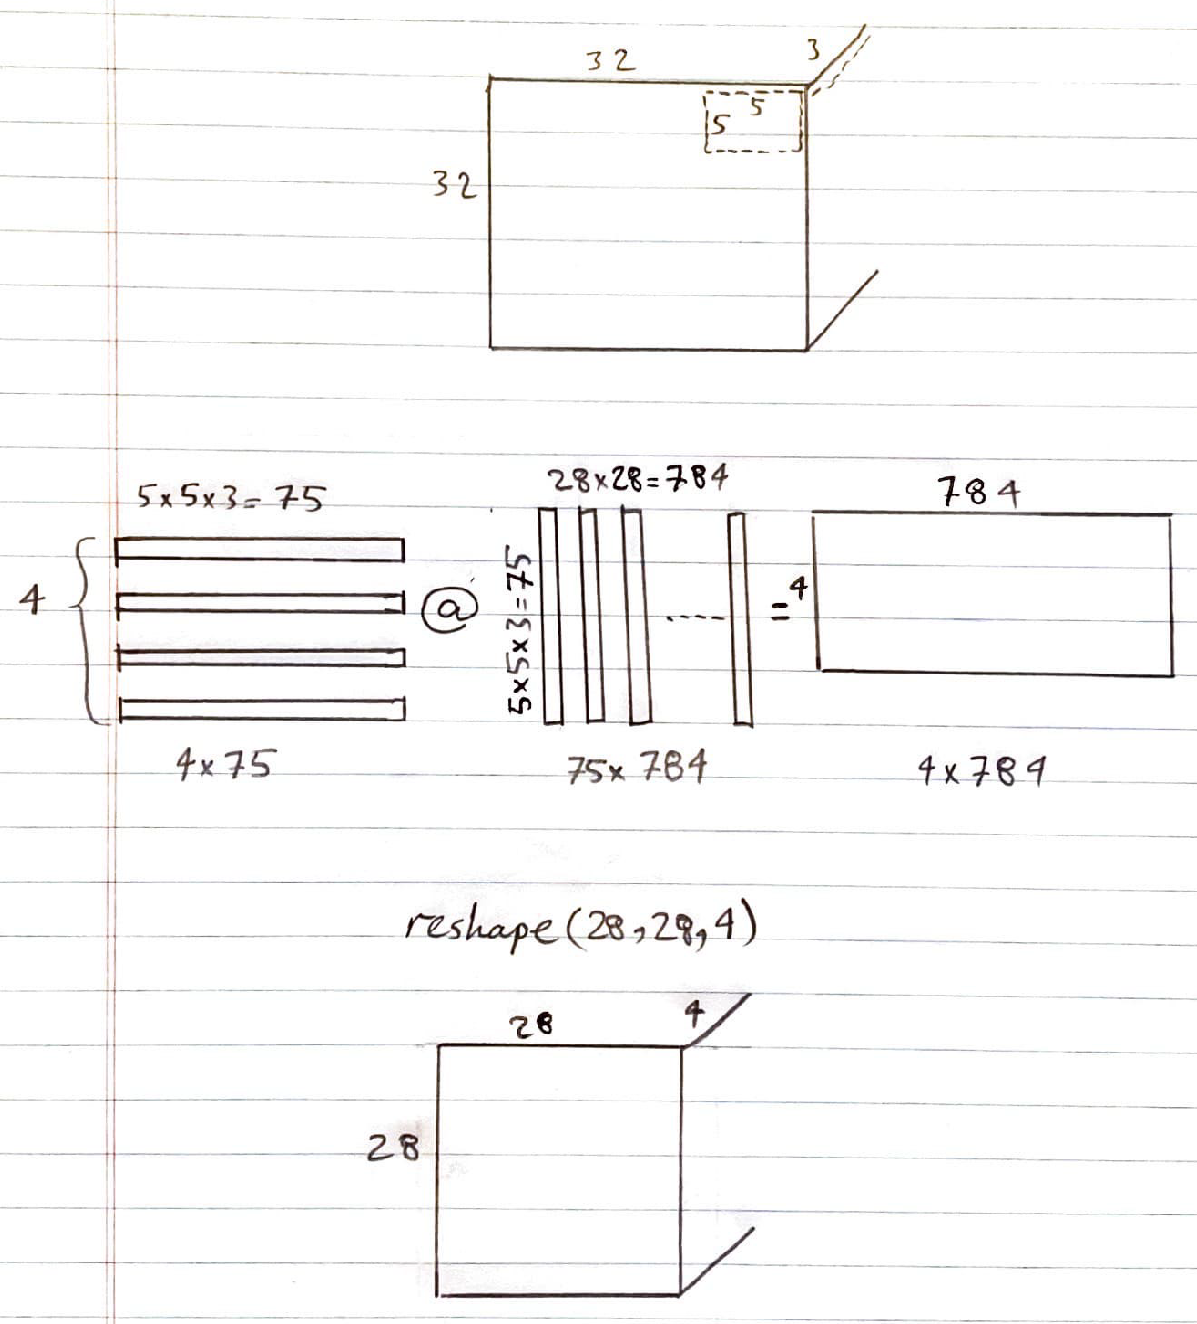

In [ ]:
# Standard libraries
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# torch
import torch
import torch.nn as nn

# torchvision
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.manual_seed(0)
plt.style.use('dark_background')

## Importing CIFAR10 dataset

Files already downloaded and verified


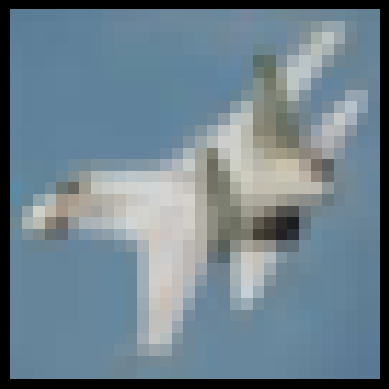

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# set the preprocess operations to be performed on train/val/test samples
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_unnormalized = transforms.Compose([transforms.ToTensor()])

# download CIFAR10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

test_set_unnormalized = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_unnormalized)
test_loader_unnormalized = torch.utils.data.DataLoader(dataset=test_set_unnormalized, batch_size=32, shuffle=False)

CIFAR10_example_image = next(iter(test_loader))[0][0]
CIFAR10_example_image_unnormalized = next(iter(test_loader_unnormalized))[0][10]

plt.imshow(transforms.ToPILImage()(CIFAR10_example_image_unnormalized))
plt.axis("off")
plt.show()

## Convolutions using `nn.Conv2d`

In [ ]:
in_channels   = 3
out_channels  = 1
img_size      = [32,32]
kernel_size   = [5,5]

In [ ]:
# using the shape formula in:
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

height_out = np.floor(((img_size[0]
                   + 2 * 0
                   - 1 * (kernel_size[0] - 1)
                   - 1) / 1) + 1).astype(int)

width_out = np.floor(((img_size[1]
                   + 2 * 0
                   - 1 * (kernel_size[1] - 1)
                   - 1) / 1) + 1).astype(int)

In [ ]:
m = nn.Conv2d(in_channels, out_channels, 5)

In [ ]:
m.weight

Parameter containing:
tensor([[[[-0.0445,  0.0310, -0.0023,  0.0916, -0.0102],
          [ 0.0306, -0.0349, -0.0227, -0.1103, -0.0765],
          [-0.0476,  0.0043,  0.0456,  0.0693, -0.0783],
          [-0.0503,  0.0419,  0.0959, -0.0238,  0.0864],
          [-0.0186,  0.0122,  0.1046, -0.1071, -0.0727]],

         [[-0.0292, -0.0450,  0.0998, -0.0748, -0.0532],
          [-0.0807, -0.1081, -0.0674,  0.0993,  0.0515],
          [ 0.0560,  0.0061, -0.0592,  0.0195, -0.1078],
          [-0.0834, -0.0595,  0.0729,  0.0677, -0.0512],
          [-0.0042,  0.0739,  0.1148,  0.0458,  0.0156]],

         [[ 0.0774, -0.0680,  0.0215, -0.0895, -0.0800],
          [-0.0596,  0.0522,  0.0464, -0.0684,  0.0349],
          [ 0.0634, -0.0146,  0.0044,  0.0268,  0.0716],
          [ 0.1109, -0.0890, -0.0423,  0.0454,  0.0957],
          [ 0.1005,  0.1019,  0.0230, -0.1004,  0.0106]]]], requires_grad=True)

In [ ]:
input = CIFAR10_example_image.unsqueeze(0)
Conv2d_output = m(input)

## Convolutions using `unfold + matmul + view`

In [ ]:
w = m.weight
b = m.bias
inp_unf = torch.nn.functional.unfold(input, kernel_size)

In [ ]:
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2) + b

In [ ]:
im2col_output = out_unf.view(1, 1, height_out, width_out)

In [ ]:
print('w.shape = '+str(w.shape))
print('inp_unf.shape = '+str(inp_unf.shape))
print('out_unf.shape = '+str(out_unf.shape))
print('out.shape = '+str(im2col_output.shape))

w.shape = torch.Size([1, 3, 5, 5])
inp_unf.shape = torch.Size([1, 75, 784])
out_unf.shape = torch.Size([1, 1, 784])
out.shape = torch.Size([1, 1, 28, 28])


## Comparing the output of the two convolutions

In [ ]:
(Conv2d_output - im2col_output).abs().max()

tensor(1.4901e-07, grad_fn=<MaxBackward1>)

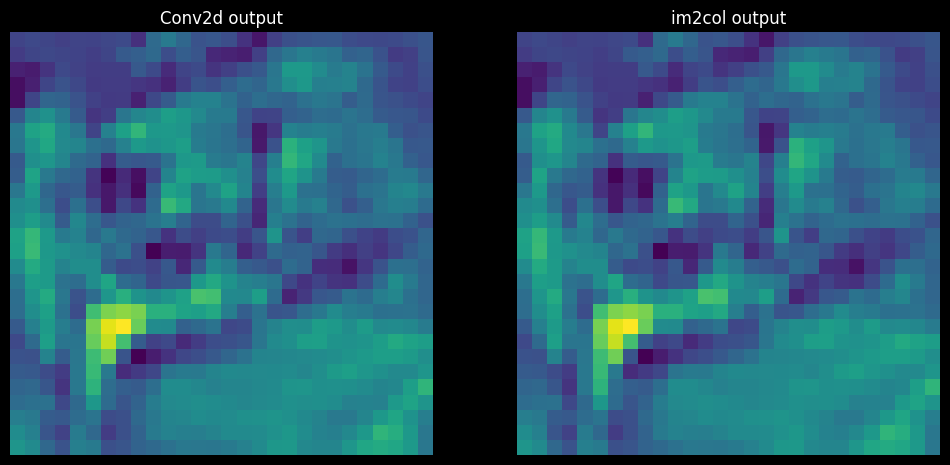

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(Conv2d_output.squeeze().detach().numpy())
ax1.set_title('Conv2d output')
ax1.axis("off")

ax2.imshow(im2col_output.squeeze().detach().numpy())
ax2.set_title('im2col output')
ax2.axis("off")

plt.show()